**PART A : PCA**


## Import required libraries

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

## Load MNIST dataset using TensorFlow

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Normalize pixel values and reshape


In [ ]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0


train_data = x_train.reshape((-1, 28*28))
test_data = x_test.reshape((-1, 28*28))

## Reconstrution function

In [ ]:
def mean_squared_error(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    return mse

In [ ]:
pca_mse_values = []

new_images = []
latent_dims = [2, 4, 8, 16, 32, 64]

for latent_dim in latent_dims:

    pca = PCA(n_components=latent_dim)           # Applying PCA
    pca.fit(train_data)
    transformed_data = pca.transform(test_data)
    reconstructed_image = pca.inverse_transform(transformed_data)


    mse = mean_squared_error(test_data.flatten(), reconstructed_image.flatten())
    pca_mse_values.append(mse)

    new_images.append(reconstructed_image)

## PLOT

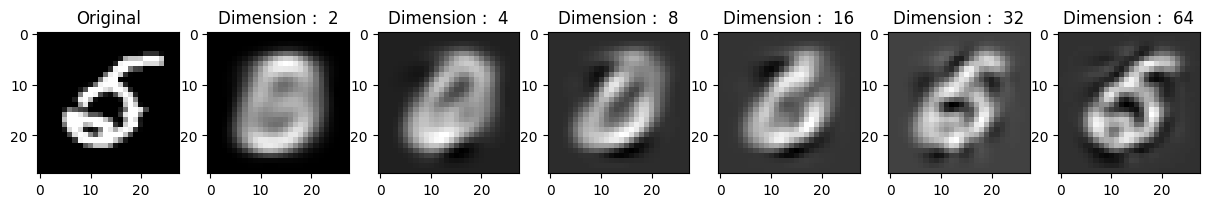

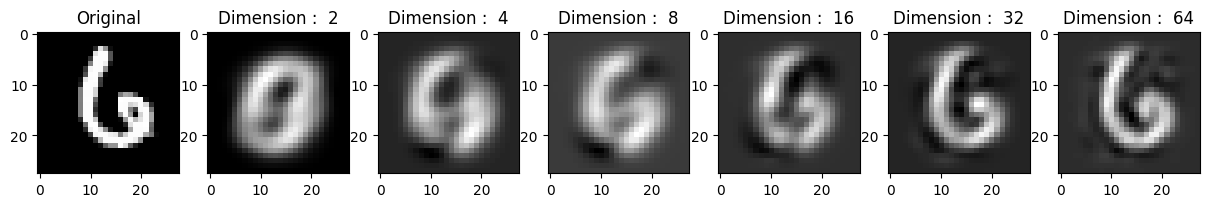

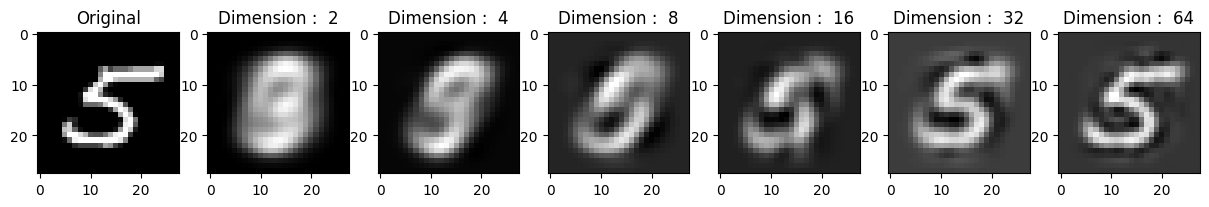

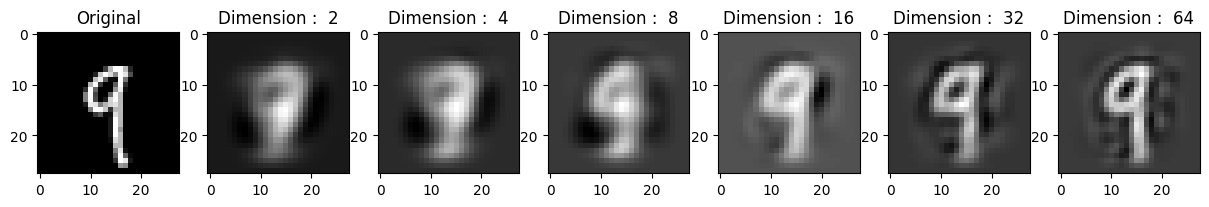

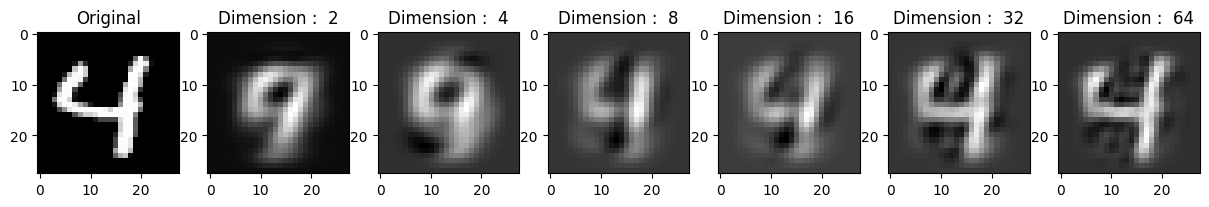

In [ ]:
for i in range(5):
    random_value = np.random.randint(0, 10000)
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 7, 1)
    plt.imshow(test_data[random_value].reshape(28, 28) * 255, cmap='gray')
    plt.title('Original')

    for j, latent_dim in enumerate(latent_dims):
        plt.subplot(1, 7, j+2)
        plt.imshow(new_images[j][random_value].reshape(28, 28) * 255, cmap='gray')
        plt.title(f'Dimension :  {latent_dim}')

    plt.show()

## Error :

In [ ]:
for i in range(len(latent_dims)):
    print(f'Latent dimension : {latent_dims[i]}, mean squared error : {pca_mse_values[i]}')

Latent dimension : 2, mean squared error : 0.05566943436861038
Latent dimension : 4, mean squared error : 0.04790343716740608
Latent dimension : 8, mean squared error : 0.03744103014469147
Latent dimension : 16, mean squared error : 0.026860447600483894
Latent dimension : 32, mean squared error : 0.016828421503305435
Latent dimension : 64, mean squared error : 0.009047232568264008


**Part B : Probabilistic PCA**

## Importing data

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()
x_test = x_test.astype('float32') / 255.0

num_samples, img_height, img_width = x_test.shape
x_test_flat = x_test.reshape((num_samples, img_height * img_width))

## Probabilistic PCA function

In [ ]:
def probabilistic_pca(data, latent_dim):

    mean_data = np.mean(data, axis=0)                # centering the data
    centered_data = data - mean_data
    cov_matrix = np.cov(centered_data.T)


    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)


    indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[:, indices]
    w_pca = eigenvectors[:, :latent_dim]


    z = np.dot(centered_data, w_pca)
    x_reconstructed = mean_data + np.dot(z, w_pca.T)

    return x_reconstructed

## Implement Probabilistic PCA

In [ ]:
latent_dims = [2, 4, 8, 16, 32, 64]

reconstructed_images = []
PPCA_mse_values = []


for latent_dim in latent_dims:

    x_reconstructed = probabilistic_pca(x_test_flat, latent_dim)


    mse_val = np.mean(np.square(x_test_flat - x_reconstructed))
    PPCA_mse_values.append(mse_val)
    reconstructed_images.append(x_reconstructed.reshape((num_samples, img_height, img_width)))



## Error

In [ ]:
for i, latent_dim in enumerate(latent_dims):
    print(f"Latent variable dimension {latent_dim}:")
    print(f"Mean Squared Error: {PPCA_mse_values[i]}")

Latent variable dimension 2:
Mean Squared Error: 0.0555498799470845
Latent variable dimension 4:
Mean Squared Error: 0.047753196890862645
Latent variable dimension 8:
Mean Squared Error: 0.03727838784001984
Latent variable dimension 16:
Mean Squared Error: 0.026682248452217543
Latent variable dimension 32:
Mean Squared Error: 0.01667477271644619
Latent variable dimension 64:
Mean Squared Error: 0.008919287743471432


## Plot

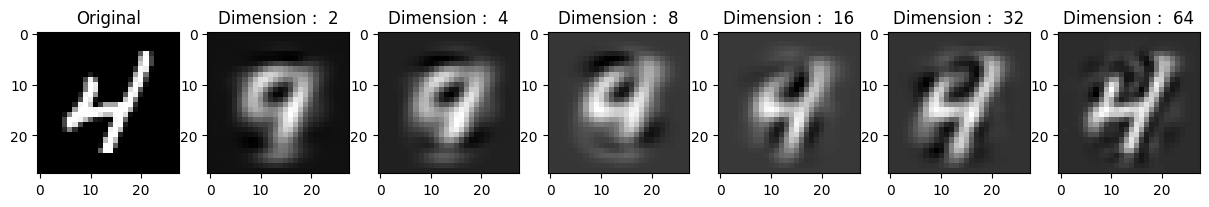

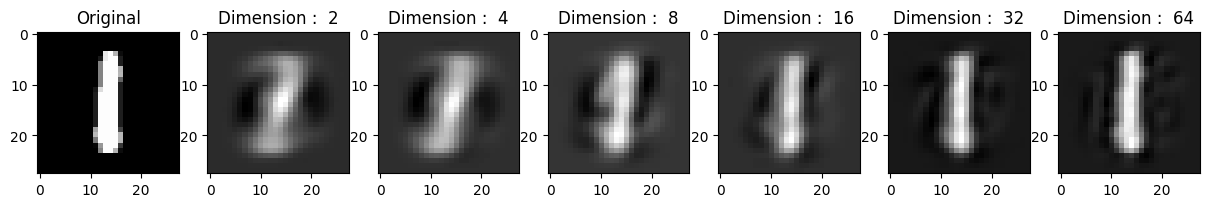

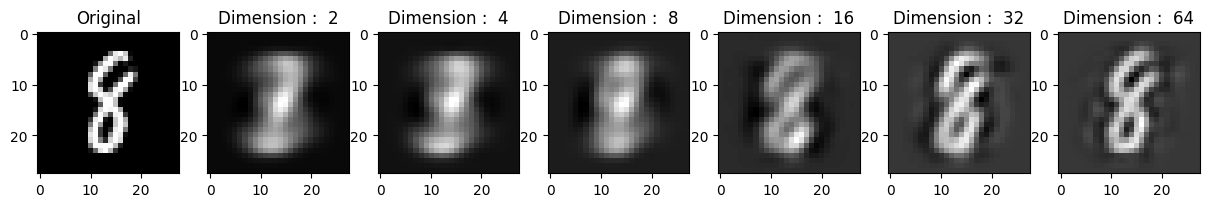

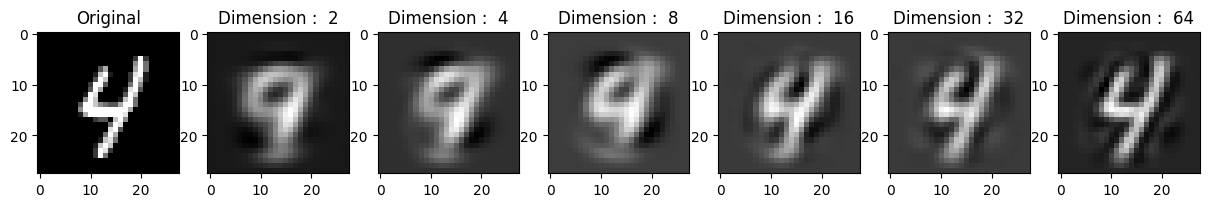

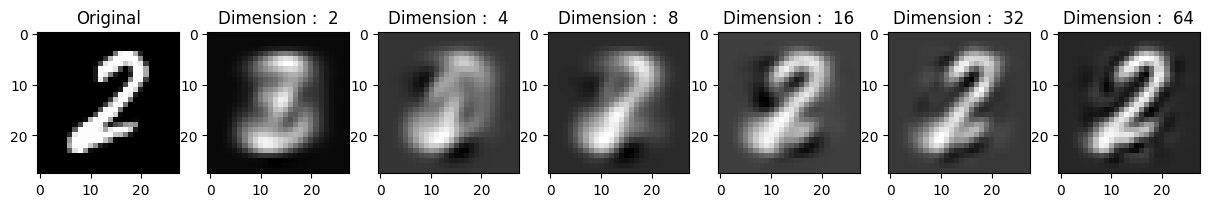

In [ ]:
for i in range(5):
    random_value = np.random.randint(0, 10000)
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 7, 1)
    plt.imshow(x_test[random_value].reshape(28, 28) , cmap='gray')
    plt.title('Original')

    for j, latent_dim in enumerate(latent_dims):
        plt.subplot(1, 7, j+2)
        plt.imshow(reconstructed_images[j][random_value].reshape(28, 28) , cmap='gray')
        plt.title(f'Dimension :  {latent_dim}')

    plt.show()


**Part C : Variational Autoencoder**

## Importing required libraries and importing dataset

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Lambda
from tensorflow.keras.models import Model



# Load dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))      # creating channel for CNN
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

## Defining autoencoder model

In [ ]:
def build_vae(latent_dim):
    # Encoder
    encoder_inputs = Input(shape=(28, 28, 1))
    x = Conv2D(2, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = Conv2D(2, 3, activation='relu', strides=2, padding='same')(x)
    x = Flatten()(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)


    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling)([z_mean, z_log_var])

    # Decoder
    decoder_inputs = Input(shape=(latent_dim,))
    x = Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(2, 3, activation='relu', strides=2, padding='same')(x)

    x = Conv2DTranspose(2, 3, activation='relu', strides=2, padding='same')(x)

    decoder_outputs = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)


    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')              # Defining models
    decoder = Model(decoder_inputs, decoder_outputs, name='decoder')
    vae_outputs = decoder(encoder(encoder_inputs)[2])
    vae = Model(encoder_inputs, vae_outputs, name='vae')

    return vae                                                                          # returning model


def calculate_mse(y_true, y_pred):                                                    # Function to calculate Mean Squared Error
    mse = np.mean(np.square(y_true - y_pred))
    return mse

##  Build VAE models, reconstruct images, and calculate MSE

In [ ]:
latent_dims = [2,4,8,16,32,64]


mse_values = []
reconstructed_images = []
for latent_dim in latent_dims:
    vae = build_vae(latent_dim)
    vae.compile(optimizer='adam', loss='mse')
    vae.fit(x_train, x_train, epochs=10,validation_data=(x_test, x_test))


    reconstructed = vae.predict(x_test)
    reconstructed_images.append(reconstructed)


    mse = calculate_mse(x_test, reconstructed)
    mse_values.append(mse)
    print(f"Latent Dimension {latent_dim}: MSE = {mse}")

vae_mse_values = mse_values

Epoch 1/10
1875/1875 [==============================] - 30s 15ms/step - loss: 0.0653 - val_loss: 0.0549
Epoch 2/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0534 - val_loss: 0.0526
Epoch 3/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0518 - val_loss: 0.0513
Epoch 4/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0509 - val_loss: 0.0506
Epoch 5/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0504 - val_loss: 0.0504
Epoch 6/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0501 - val_loss: 0.0501
Epoch 7/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0499 - val_loss: 0.0499
Epoch 8/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0498 - val_loss: 0.0497
Epoch 9/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0497 - val_loss: 0.0496
Epoch 10/10
313/313 [==============================] - 2s 5ms/st

## Error





In [ ]:
for i, latent_dim in enumerate(latent_dims):
    print(f"Latent variable dimension {latent_dim}:")
    print(f"Mean Squared Error: {mse_values[i]}")

Latent variable dimension 2:
Mean Squared Error: 0.04960004612803459
Latent variable dimension 4:
Mean Squared Error: 0.03489534556865692
Latent variable dimension 8:
Mean Squared Error: 0.021356122568249702
Latent variable dimension 16:
Mean Squared Error: 0.010884972289204597
Latent variable dimension 32:
Mean Squared Error: 0.005636072251945734
Latent variable dimension 64:
Mean Squared Error: 0.004211121704429388


## 5 random images

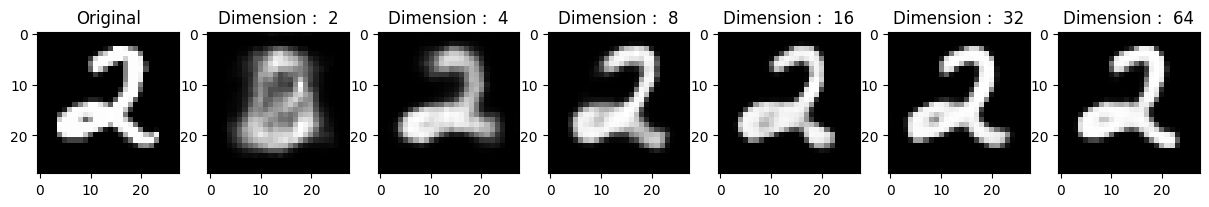

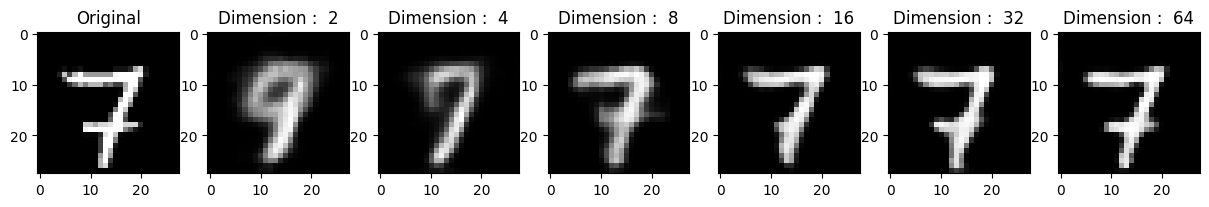

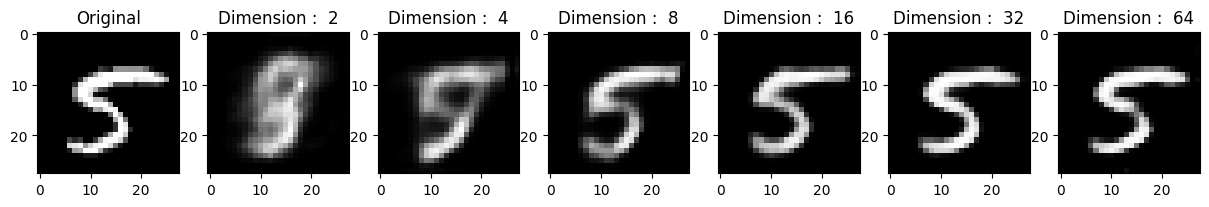

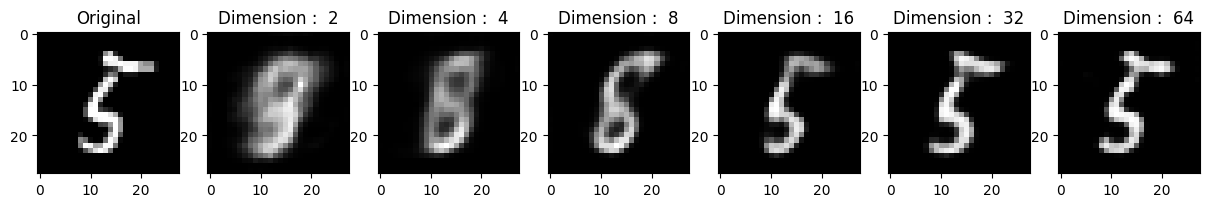

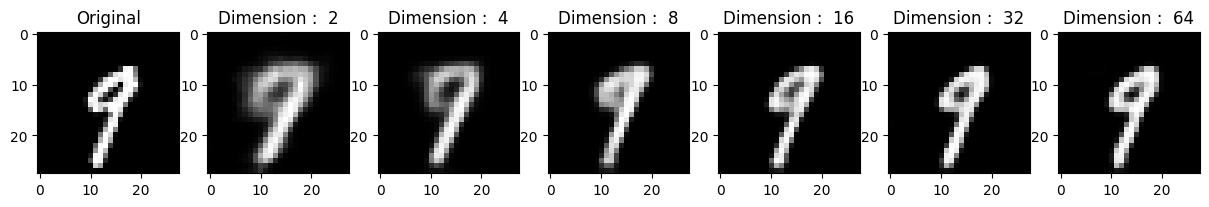

In [ ]:
for i in range(5):
    random_value = np.random.randint(0, 10000)
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 7, 1)
    plt.imshow(x_test[random_value].reshape(28, 28) * 255, cmap='gray')
    plt.title('Original')

    for j, latent_dim in enumerate(latent_dims):
        plt.subplot(1, 7, j+2)
        plt.imshow(reconstructed_images[j][random_value].reshape(28, 28) * 255, cmap='gray')
        plt.title(f'Dimension :  {latent_dim}')

    plt.show()


**MSE vs Latent Variable Dimension**

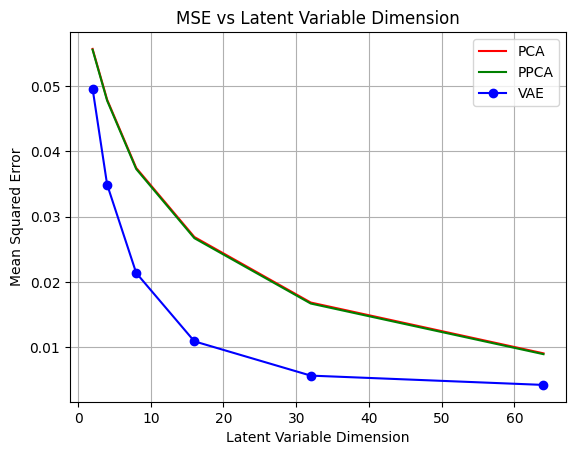

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the following variables:
# latent_dims, pca_mse_values, PPCA_mse_values, vae_mse_values

plt.plot(latent_dims, pca_mse_values, color='red', label='PCA')
plt.plot(latent_dims, PPCA_mse_values, color='green', label='PPCA')
plt.plot(latent_dims, vae_mse_values, color='blue', label='VAE', marker='o')

plt.title('MSE vs Latent Variable Dimension')
plt.xlabel('Latent Variable Dimension')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.legend()
plt.show()


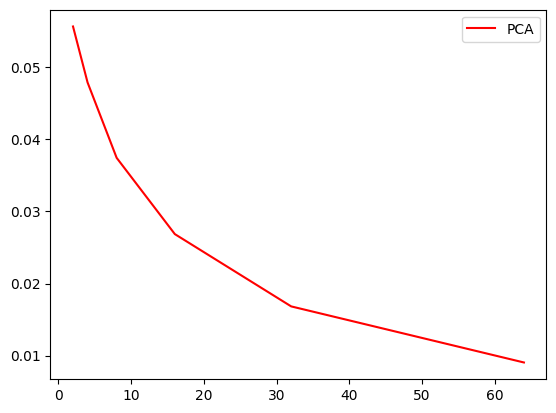

In [ ]:
plt.plot(latent_dims, pca_mse_values, color='red', label='PCA')
plt.legend()